In [1]:
import pandas as pd
import numpy as np
from IPython.display import display_html
import matplotlib.pyplot as plt
import numpy as np
import xlsxwriter
import math
from sklearn.cluster import KMeans
pd.options.mode.chained_assignment = None  # default='warn'

In [2]:
def convert_excel(path, sheet_name = 'Ark1', pri = True):
    df = pd.read_excel(path, sheet_name)
    if pri:
        print('The first 5 rows of the loaded data:')
        display_html(df.head())
    return df

def choose_headers(df, headers_list, pri):
    temp_df = pd.DataFrame()
    for i in range(len(headers_list)):
        if pri:
            print('Choosing the column "', headers_list[i], '"')
        temp_df = pd.concat([temp_df, df[headers_list[i]]], axis = 1)
    return temp_df

def remove_nan(df):
    df = df.dropna().reset_index(drop=True)
    return df

def choose_subsets(df, column_str_list, subset_str_list, pri):
    temp_df = pd.DataFrame()
    for i in range(len(column_str_list)):
        if pri:
            print('Choosing the rows with "', subset_str_list[i], '" in the "', column_str_list[i], '" column.')
        temp_df = pd.concat([temp_df, df[df[column_str_list[i]] == subset_str_list[i]]])
    return temp_df

# Function to convert the dataframe back into an excel sheet.
# More options will follow if there needs to be more sheets etc.
# Inputs: Dataframe as converted by convert_excel, the name you wish the excel file to have (remember .xlsx)
def convert_dataframe(df, name_str):
    file = df.to_excel(name_str)



## Strategi for data:
- Identificer hvor mange patenter fra de forskellige lande (forskel mellem længden af DK patenter fundet her og miljøteknologi dataen "på tværs af teknikområder"). **DONE**
- Hvor mange virksomheder er disse patenter spredt over, hvilke virksomheder står for størstedelen af patenterne? Sammenlign dette med størrelsen af virksomheden. Er der nogen virksomheder som stikker ud i forhold til at de er en lille virksomhed, men med mange patentansøgninger og vice versa? **GØR DETTE FOR DK** **SPURGT EMIL**
- Hvilke år har været gode? Har f.eks. corona påvirket dette? **DONE**
- Gruppér lande pba deres patentsøgninger indenfor de forskellige teknikområder.
- HUSK AT KIGGE PÅ PATENTER PR. 100.000 INDBYGGERE. **DONE**
- Kan de andre kolonner bruges til noget? "publn_auth", "family_id", "publn_nr"? 
- Måske noget med eu_members
- Kig efter hvor danmark har flest patenter, hvilke teknikområder

In [3]:
df_rådata = convert_excel("Miljøteknologi rådata.xlsx", sheet_name="DATA_til_eksport_v2", pri=False)
df_countrycodes = convert_excel("Countrycodes.xlsx", sheet_name="Countrycodes", pri=False)
df_populations = convert_excel("world_population.xlsx", sheet_name="world_population", pri=False)

In [4]:
df_dk = choose_subsets(df_rådata, ["person_ctry_code"], ["DK"], True)
len(df_dk)

Choosing the rows with " DK " in the " person_ctry_code " column.


1528

In [5]:
print("There are ", len(df_dk["psn_name"].unique()), " different companies who requested a patent in the years 2011 - 2022 from Denmark")

There are  334  different companies who requested a patent in the years 2011 - 2022 from Denmark


In [6]:
print("There are ", len(df_rådata["person_ctry_code"].unique()), " different countries in the data")

There are  93  different countries in the data


## Omdanner rådata til at være patenter pr. 100.000 indbyggere

### Mapper navnene fra countrycodes over til udskrevne navne (Her er der nogen som får et lidt mærkeligt navn, det bliver addresseret senere)

In [7]:
list1 = list(df_countrycodes["Column2"])
list2 = list(df_countrycodes["Column1"])

In [8]:
replacement_map = {l1: l2 for l1, l2 in zip(list1, list2)}
df_rådata["person_ctry_code"] = df_rådata["person_ctry_code"].map(replacement_map)

In [9]:
pop = df_populations[["Country/Territory","2022 Population"]]
pop["Population / 100000"] = pop["2022 Population"]/100000

In [10]:
patents = df_rådata.groupby(["person_ctry_code"]).size()

In [11]:
pop = choose_subsets(pop, ["Country/Territory" for i in range(len(list(patents.keys())))], list(patents.keys()), pri=False)

##### Der er pt kun 88 af landende som kommer videre fra dataframen, ud af de 93 der er i rådata. (navneforskel)?

In [12]:
list(set(list(patents.keys()))-set(list(pop["Country/Territory"])))

['Virgin Islands, British',
 'Russian Federation',
 'CuraÃ§ao',
 'Taiwan, Province of China',
 'Korea, Republic of']

##### Manuel tilføjelse af de sidste 5 til dataen

In [13]:
pop.loc[1000] = ["Taiwan", 23893394, 23893394/100000]
pop.loc[1001] = ["Curacao", 191163, 191163/100000]
pop.loc[1002] = ["South Korea", 51815810, 51815810/100000]
pop.loc[1003] = ["Russia", 144713314, 144713314/100000]
pop.loc[1004] = ["United States Virgin Islands", 99465, 99465/100000]

### Nu indeholder "pop" 93 lande, som stemmer overens med de 93 unikke lande der indgår i patentdataen. I "pop" er der population og population/100000

## Hvilke lande har flest patentansøgninger pr. 100.000 indbyggere

In [14]:
df_rådata['person_ctry_code'] = df_rådata['person_ctry_code'].str.replace("Virgin Islands, British","United States Virgin Islands")
df_rådata['person_ctry_code'] = df_rådata['person_ctry_code'].str.replace("CuraÃ§ao","Curacao")
df_rådata['person_ctry_code'] = df_rådata['person_ctry_code'].str.replace("Korea, Republic of","South Korea")
df_rådata['person_ctry_code'] = df_rådata['person_ctry_code'].str.replace("Taiwan, Province of China","Taiwan")
df_rådata['person_ctry_code'] = df_rådata['person_ctry_code'].str.replace("Russian Federation","Russia")

In [15]:
patents = df_rådata.groupby(["person_ctry_code"]).size()
pop = pop.sort_values(by=["Country/Territory"])

#### Antallet af patenter pr. 100.000 indbyggere:

In [16]:
num_patents = list(df_rådata.groupby(["person_ctry_code"]).size().values)
num_100000 = list(pop["Population / 100000"])
res = [i / j for i, j in zip(num_patents, num_100000)]
df_patents = pd.DataFrame(patents)
df_patents = df_patents.rename(columns = {0:"Patents"})
df_patents["2022 Inhabitants"] = list(pop["2022 Population"])
df_patents["patents/(inhabitants/100000)"] = res

#### Top 15 lande :  patenter/100000 indbyggere

In [17]:
df_patents.sort_values(by=["patents/(inhabitants/100000)"], ascending=False)[0:15]

,Patents,2022 Inhabitants,patents/(inhabitants/100000)
person_ctry_code,,,
Luxembourg,359,647599,55.435540
United States Virgin Islands,52,99465,52.279696
Switzerland,4043,8740472,46.256083
Finland,1999,5540745,36.078181
Monaco,10,36469,27.420549
Denmark,1528,5882261,25.976406
Netherlands,3573,17564014,20.342730
Sweden,2059,10549347,19.517796
Germany,15501,83369843,18.593054


#### Top 25 lande : Udelukkende indbyggere

In [18]:
df_patents.sort_values(by=["2022 Inhabitants"], ascending=False)[0:15]

,Patents,2022 Inhabitants,patents/(inhabitants/100000)
person_ctry_code,,,
China,160,1425887337,0.011221
India,18,1417173173,0.001270
United States,58544,338289857,17.305869
Indonesia,2,275501339,0.000726
Brazil,34,215313498,0.015791
Bangladesh,1,171186372,0.000584
Russia,14,144713314,0.009674
Mexico,26,127504125,0.020391
Japan,21301,123951692,17.184921


### Hvilke år har været gode? Har f.eks. corona påvirket dette?

In [19]:
top_15 = list(df_patents.sort_values(by=["patents/(inhabitants/100000)"], ascending=False)[0:15].index)

In [20]:
top_15_grouped = df_rådata.groupby(["person_ctry_code", "earliest_publn_year"]).size().loc[top_15]

In [21]:
top_15_grouped_normed = top_15_grouped
for country in top_15:
    patents_sum = (df_rådata.groupby(["person_ctry_code", "earliest_publn_year"]).size().loc[country].sum())
    patents_norm = df_rådata.groupby(["person_ctry_code", "earliest_publn_year"]).size().loc[country].values/patents_sum
    top_15_grouped_normed.loc[country] = patents_norm

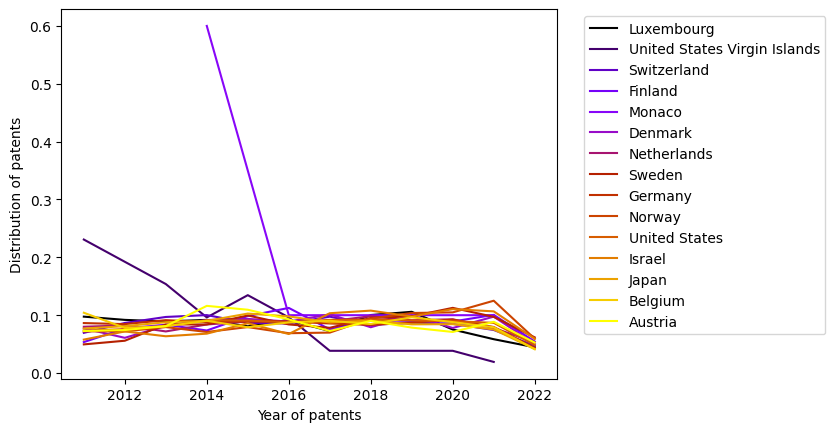

In [22]:
cmap = plt.get_cmap('gnuplot')
colors = [cmap(i) for i in np.linspace(0, 1, len(top_15))]

i=0
for country in top_15:
    plt.plot(top_15_grouped_normed.loc[country], label=country, color=colors[i])
    i += 1

plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
plt.ylabel("Distribution of patents")
plt.xlabel("Year of patents")
plt.show()

## Virksomheder inden for de forskellige lande

In [23]:
companies_grouped = df_rådata.groupby(["person_ctry_code", "psn_name"]).size()

In [24]:
countries = list(df_rådata["person_ctry_code"].unique())
companies_spread_dict = {}

for country in countries:
    companies_spread_dict[country] = companies_grouped.loc[country].sum()/len(companies_grouped.loc[country])

In [25]:
companies_spread_dict = dict(sorted(companies_spread_dict.items(), key=lambda item: item[1], reverse=True))

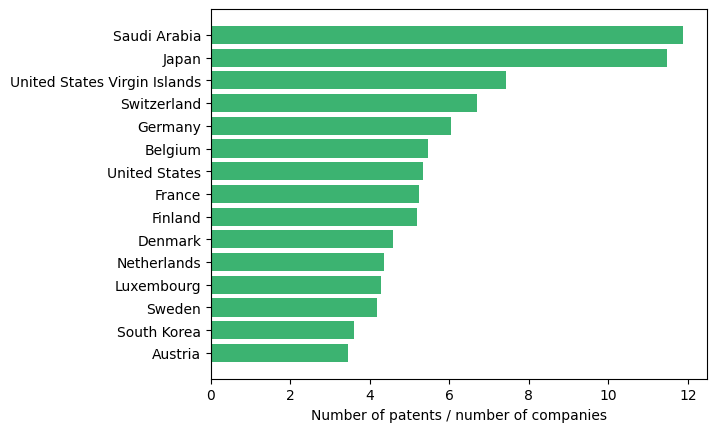

In [26]:
k = 15
top_k_spread = dict(list(companies_spread_dict.items())[:k])

fig, ax = plt.subplots()
ax.barh(list(top_k_spread.keys()),list(top_k_spread.values()), color = 'mediumseagreen')
ax.set_xlabel("Number of patents / number of companies")
ax.invert_yaxis()

## Danske virksomheder EXCEL ARK MED OPSLAG

In [27]:
DK_companies = pd.DataFrame(companies_grouped.loc["Denmark"])
DK_companies = DK_companies.rename(columns={0:"Antal Patenter"})

In [28]:
DK_companies = DK_companies.sort_values(by=["Antal Patenter"], ascending=False)
DK_companies_df = pd.DataFrame(DK_companies)
#convert_dataframe(DK_companies_df, "Danske_Virksomheder_patentansøgninger.xlsx")

## Gruppering af lande indenfor teknikområder

In [29]:
df_rådata.head()

,docdb_family_id,publn_auth,publn_nr,earliest_publn_year,psn_name,person_ctry_code,eu_member,Affald,Klimatilpasning,Luft,Natur,Vand
0,3833063,US,2012090604,2012,MAP PHARMACEUTICALS,United States,NaN,NaN,NaN,Y,NaN,NaN
1,3833063,US,2014086994,2014,MAP PHARMACEUTICALS,United States,NaN,NaN,NaN,Y,NaN,NaN
2,4166382,US,2012023992,2012,SANUVOX TECHNOLOGIES,Canada,NaN,NaN,NaN,Y,NaN,NaN
3,4169520,US,2011045576,2011,CO2 SOLUTIONS,Canada,NaN,NaN,NaN,Y,NaN,NaN
4,4169520,US,2011183397,2011,CO2 SOLUTIONS,Canada,NaN,NaN,NaN,Y,NaN,NaN


In [30]:
df_rådata['Affald'] = df_rådata['Affald'].str.replace("Y","Affald")
df_rådata['Klimatilpasning'] = df_rådata['Klimatilpasning'].str.replace("Y","Klimatilpasning")
df_rådata['Luft'] = df_rådata['Luft'].str.replace("Y","Luft")
df_rådata['Natur'] = df_rådata['Natur'].str.replace("Y","Natur")
df_rådata['Vand'] = df_rådata['Vand'].str.replace("Y","Vand")

In [31]:
cols = ["Affald", "Klimatilpasning", "Luft", "Natur", "Vand"]
Teknikområde =  df_rådata[cols].apply(lambda x: x.str.cat(sep=' '), axis=1)
df_rådata["Teknikområde"] = Teknikområde

In [32]:
vand = df_rådata.groupby(["person_ctry_code", "Vand"]).size()
vand.name = "vand"
affald = df_rådata.groupby(["person_ctry_code", "Affald"]).size()
affald.name = "affald"
klimatilpasning = df_rådata.groupby(["person_ctry_code", "Klimatilpasning"]).size()
klimatilpasning.name = "klimatilpasning"
luft = df_rådata.groupby(["person_ctry_code", "Luft"]).size()
luft.name = "luft"
natur = df_rådata.groupby(["person_ctry_code", "Natur"]).size()
natur.name = "natur"

In [33]:
df_rådata.groupby(["person_ctry_code", "Vand"]).size()

person_ctry_code              Vand
Algeria                       Vand        2
Andorra                       Vand        4
Argentina                     Vand        3
Australia                     Vand       12
Austria                       Vand      268
                                      ...  
United Arab Emirates          Vand        8
United Kingdom                Vand      107
United States                 Vand    20470
United States Virgin Islands  Vand        8
Uruguay                       Vand        2
Length: 65, dtype: int64

#### Når der er nogen patenter som går over flere teknikområder, bliver de her talt med for hver gang de fremgår inden for et teknikområde. Så begge gange vil blive talt.

#### Nu er der både et dict som viser hvor mange samlede teknikområder de forskellige lande rækker sig over, og et dict som viser hvor mange patenter de forskellige lande har for hvert teknikområde (et dict for hvert område)

#### Mangler at dividere med 100000 for hver, så dette også fremgår

In [34]:
teknikområder_dict = {}
teknikområder = [vand, affald, klimatilpasning, luft, natur]

for country in countries:
    total = 0
    for teknikområde in teknikområder:
        try:
            total += teknikområde[country].sum()
        except:
            total += 0
    teknikområder_dict[country] = total

In [35]:
sorted_dict = dict(sorted(teknikområder_dict.items()))

In [36]:
def set_per_100000(data, set_p = True):
    final_data = []
    final_namelist = []
    temp_data = list(data.keys())
    for i in range(len(temp_data)):
        if type(data) == pd.core.series.Series:
            country = temp_data[i][0]
            final_namelist.append(country)
        if type(data) == dict:
            country = temp_data[i]
            final_namelist.append(country)
        pop_100000 = float(pop[pop["Country/Territory"] == country]['Population / 100000'])
        if set_p:
            adjusted_patents = float(data[country])/pop_100000
        else: 
            adjusted_patents = float(data[country])
        final_data.append(adjusted_patents)
    return final_namelist, final_data
            
    
    

In [37]:
def create_feature_frame(list_of_data, list_of_names_str, set_p = True):
    final_df = pd.DataFrame()
    for i in range(len(list_of_data)):
        temp_dataframe = pd.DataFrame()
        temp_dataframe["country"], temp_dataframe[list_of_names_str[i]] = set_per_100000(list_of_data[i], set_p)
        if i == 0:
            final_df = temp_dataframe
        else:
            final_df = pd.merge(final_df, temp_dataframe, "outer")
        final_df = final_df.replace(np.nan, 0)
    return final_df
    

#### Her har jeg forsøgt mig med unsupervised learning for at finde ud af hvilke grupperinger der er blandt landende og deres patentansøgninger inden for de forskellige teknikområder. Det viser sig med denne fremgangsmåde, at den blot har kigget på mængden af patenter i det hele taget, og ikke så meget på hvilke teknikområder er blevet prioriseret. Dette vil blive kigget på efter.

In [38]:
patents_dict = patents.to_dict()
x = create_feature_frame([vand, luft, affald, klimatilpasning, natur, patents_dict], ["Vand", "Luft", "Affald", "Klimatilpasning", "Natur", "antal patenter"])

In [39]:
x

,country,Vand,Luft,Affald,Klimatilpasning,Natur,antal patenter
0,Algeria,0.004454,0.000000,0.000000,0.000000,0.000000,0.004454
1,Andorra,5.011024,0.000000,0.000000,0.000000,0.000000,5.011024
2,Argentina,0.006592,0.006592,0.019776,0.010987,0.000000,0.043946
3,Australia,0.045841,0.034381,0.076402,0.068762,0.003820,0.217745
4,Austria,2.997891,4.742932,6.454415,0.592867,0.033558,13.389835
...,...,...,...,...,...,...,...
88,Gabon,0.000000,0.000000,0.000000,0.041859,0.000000,0.041859
89,Madagascar,0.000000,0.000000,0.000000,0.003377,0.003377,0.003377
90,Philippines,0.000000,0.000000,0.000000,0.001731,0.000000,0.001731
91,Uzbekistan,0.000000,0.000000,0.000000,0.002888,0.000000,0.002888


In [40]:
y = x.drop(["country"], axis = 1)
y = y.drop(["antal patenter"], axis = 1)

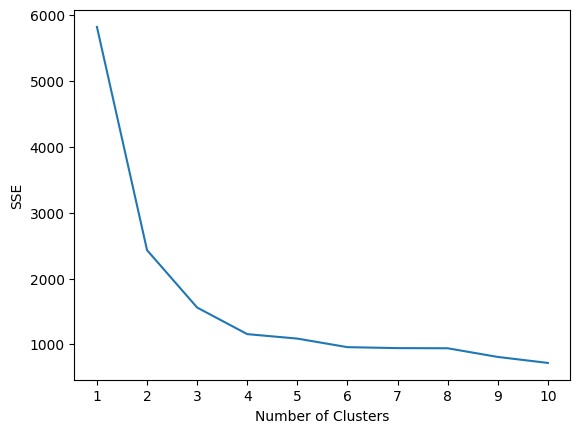

In [41]:
#initialize kmeans parameters
kmeans_kwargs = {
"init": "random",
"n_init": 10,
"random_state": 1,
}

#create list to hold SSE values for each k
sse = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(y)
    sse.append(kmeans.inertia_)

#visualize results
plt.plot(range(1, 11), sse)
plt.xticks(range(1, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

In [42]:
kmeans = KMeans(n_clusters=3, **kmeans_kwargs)
kmeans.fit(y)

KMeans(init='random', n_clusters=3, n_init=10, random_state=1)

In [43]:
y["country"] = x["country"]
y["cluster"] = kmeans.labels_
y

,Vand,Luft,Affald,Klimatilpasning,Natur,country,cluster
0,0.004454,0.000000,0.000000,0.000000,0.000000,Algeria,0
1,5.011024,0.000000,0.000000,0.000000,0.000000,Andorra,0
2,0.006592,0.006592,0.019776,0.010987,0.000000,Argentina,0
3,0.045841,0.034381,0.076402,0.068762,0.003820,Australia,0
4,2.997891,4.742932,6.454415,0.592867,0.033558,Austria,1
...,...,...,...,...,...,...,...
88,0.000000,0.000000,0.000000,0.041859,0.000000,Gabon,0
89,0.000000,0.000000,0.000000,0.003377,0.003377,Madagascar,0
90,0.000000,0.000000,0.000000,0.001731,0.000000,Philippines,0
91,0.000000,0.000000,0.000000,0.002888,0.000000,Uzbekistan,0


In [44]:
y[y["cluster"]==2]

,Vand,Luft,Affald,Klimatilpasning,Natur,country,cluster
20,9.511356,7.219246,20.989957,1.534090,1.353609,Finland,2
38,18.838818,18.684402,19.765318,2.007415,0.926499,Luxembourg,2
40,2.742055,2.742055,21.936439,0.000000,21.936439,Monaco,2
56,15.857267,15.811503,13.889410,4.484884,0.469082,Switzerland,2
63,8.043030,9.048409,40.215151,0.000000,0.000000,United States Virgin Islands,2


In [45]:
y[y["cluster"]==1]

,Vand,Luft,Affald,Klimatilpasning,Natur,country,cluster
4,2.997891,4.742932,6.454415,0.592867,0.033558,Austria,1
6,2.745384,4.238186,6.434493,2.702487,0.231642,Belgium,1
9,3.965744,2.283228,3.528862,0.876364,0.369269,Canada,1
16,9.605150,7.735121,8.245129,2.618041,0.714011,Denmark,1
21,3.103984,3.512484,4.052509,0.676192,0.287807,France,1
22,5.695105,8.154028,5.161339,1.151496,0.173924,Germany,1
30,9.194198,2.268123,2.743876,4.547311,0.719161,Israel,1
32,4.111279,9.579538,4.082236,0.615562,0.243643,Japan,1
36,2.542782,2.542782,7.628347,0.000000,0.000000,Liechtenstein,1
42,6.723976,4.845134,7.116824,3.182644,0.438396,Netherlands,1


#### Her vil der så bliver kigget på hvordan kmeans vil finde grupperinger, hvis man i stedet sammenligner landende på baggrund af deres prioritering af de forskellige teknikområder ud af det samlede antal patenter. Her skal vi igen tænke på at der godt kan være flere teknikområder end der er patenter, fordi nogen patenter rækker over flere teknikområder.

#### Starter da med at dividere antallet af patenter indenfor de forskellige teknikområder med den totale mængde af patenter for det pågældende land.

In [46]:
vand

person_ctry_code              Vand
Algeria                       Vand        2
Andorra                       Vand        4
Argentina                     Vand        3
Australia                     Vand       12
Austria                       Vand      268
                                      ...  
United Arab Emirates          Vand        8
United Kingdom                Vand      107
United States                 Vand    20470
United States Virgin Islands  Vand        8
Uruguay                       Vand        2
Name: vand, Length: 65, dtype: int64

In [47]:
patents_dict = patents.to_dict()
z = create_feature_frame([vand, luft, affald, klimatilpasning, natur, patents_dict], ["Vand", "Luft", "Affald", "Klimatilpasning", "Natur", "antal patenter"], set_p = False)
z = z[["Vand", "Luft", "Affald", "Klimatilpasning", "Natur"]].div(z["antal patenter"], axis=0)


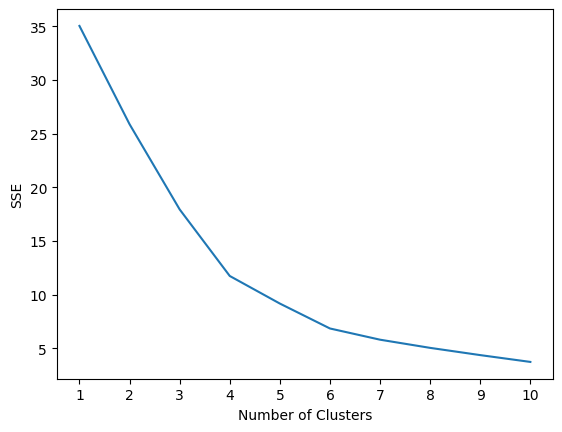

In [48]:
#initialize kmeans parameters
kmeans_kwargs = {
"init": "random",
"n_init": 10,
"random_state": 1,
}

#create list to hold SSE values for each k
sse = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(z)
    sse.append(kmeans.inertia_)

#visualize results
plt.plot(range(1, 11), sse)
plt.xticks(range(1, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

In [49]:
kmeans = KMeans(n_clusters=5, **kmeans_kwargs)
kmeans.fit(z)

KMeans(init='random', n_clusters=5, n_init=10, random_state=1)

In [50]:
z["country"] = x["country"]
z["cluster"] = kmeans.labels_
z

,Vand,Luft,Affald,Klimatilpasning,Natur,country,cluster
0,1.000000,0.000000,0.000000,0.000000,0.000000,Algeria,2
1,1.000000,0.000000,0.000000,0.000000,0.000000,Andorra,2
2,0.150000,0.150000,0.450000,0.250000,0.000000,Argentina,3
3,0.210526,0.157895,0.350877,0.315789,0.017544,Australia,3
4,0.223893,0.354219,0.482038,0.044277,0.002506,Austria,3
...,...,...,...,...,...,...,...
88,0.000000,0.000000,0.000000,1.000000,0.000000,Gabon,4
89,0.000000,0.000000,0.000000,1.000000,1.000000,Madagascar,4
90,0.000000,0.000000,0.000000,1.000000,0.000000,Philippines,4
91,0.000000,0.000000,0.000000,1.000000,0.000000,Uzbekistan,4


In [51]:
z[z["cluster"]==4]

,Vand,Luft,Affald,Klimatilpasning,Natur,country,cluster
76,0.0,0.0,1.0,1.0,0.0,Lebanon,4
84,0.0,0.0,0.0,1.0,0.0,Bangladesh,4
85,0.0,0.0,0.0,1.0,0.0,Botswana,4
86,0.0,0.0,0.0,1.0,0.0,Cook Islands,4
87,0.0,0.0,0.0,1.0,0.0,Faroe Islands,4
88,0.0,0.0,0.0,1.0,0.0,Gabon,4
89,0.0,0.0,0.0,1.0,1.0,Madagascar,4
90,0.0,0.0,0.0,1.0,0.0,Philippines,4
91,0.0,0.0,0.0,1.0,0.0,Uzbekistan,4


In [52]:
z[z["cluster"]==2]

,Vand,Luft,Affald,Klimatilpasning,Natur,country,cluster
0,1.00,0.0,0.00,0.00,0.0,Algeria,2
1,1.00,0.0,0.00,0.00,0.0,Andorra,2
5,1.00,0.0,0.00,0.00,0.0,Bahamas,2
17,1.00,0.0,0.00,0.00,0.0,Egypt,2
19,1.00,0.0,0.00,0.00,0.0,Ethiopia,2
24,1.00,0.0,0.00,0.00,0.0,Guernsey,2
29,1.00,0.0,0.00,0.00,0.0,Isle of Man,2
33,1.00,0.0,0.00,0.00,0.0,Jordan,2
34,1.00,0.0,0.00,0.00,0.0,Kuwait,2
43,0.75,0.0,0.25,0.25,0.0,New Zealand,2


In [53]:
z[z["cluster"]==1]

,Vand,Luft,Affald,Klimatilpasning,Natur,country,cluster
11,0.250000,0.000000,0.750000,0.0,0.0,Chile,1
40,0.100000,0.100000,0.800000,0.0,0.8,Monaco,1
58,1.000000,0.000000,1.000000,0.0,1.0,Tunisia,1
63,0.153846,0.173077,0.769231,0.0,0.0,United States Virgin Islands,1
68,0.000000,0.166667,0.833333,0.0,0.5,Morocco,1
70,0.000000,0.000000,1.000000,0.0,0.0,Barbados,1
71,0.000000,0.000000,1.000000,0.0,0.0,Colombia,1
72,0.000000,0.000000,1.000000,0.0,0.0,Curacao,1
74,0.000000,0.000000,1.000000,0.0,0.0,Jamaica,1
75,0.000000,0.000000,1.000000,0.0,0.0,Kazakhstan,1


In [54]:
z[z["cluster"]==0]

,Vand,Luft,Affald,Klimatilpasning,Natur,country,cluster
65,0.0,1.000000,0.000000,0.000000,0.0,Iceland,0
66,0.0,1.000000,0.000000,0.000000,0.0,Malaysia,0
67,0.0,0.769231,0.307692,0.038462,0.0,Mexico,0
69,0.0,1.000000,0.000000,0.000000,0.0,San Marino,0


In [55]:
z[z["cluster"]==3]

,Vand,Luft,Affald,Klimatilpasning,Natur,country,cluster
2,0.150000,0.150000,0.450000,0.250000,0.000000,Argentina,3
3,0.210526,0.157895,0.350877,0.315789,0.017544,Australia,3
4,0.223893,0.354219,0.482038,0.044277,0.002506,Austria,3
6,0.178372,0.275362,0.418060,0.175585,0.015050,Belgium,3
7,0.088235,0.264706,0.382353,0.294118,0.000000,Brazil,3
8,0.130435,0.304348,0.478261,0.086957,0.000000,Bulgaria,3
9,0.415871,0.239433,0.370057,0.091901,0.038724,Canada,3
10,0.500000,0.000000,0.500000,0.000000,0.000000,Cayman Islands,3
12,0.337500,0.350000,0.306250,0.125000,0.012500,China,3
13,0.307692,0.307692,0.307692,0.153846,0.000000,Croatia,3


In [80]:
Klima_cluster = list(z[z["cluster"]==4]["country"])
Vand_cluster = list(z[z["cluster"]==2]["country"])
Luft_cluster = list(z[z["cluster"]==0]["country"])
Affald_cluster = list(z[z["cluster"]==1]["country"])
Naturish_cluster = list(z[z["cluster"]==3]["country"])

#### Vil gerne give dem longitude og latitude, men pt. i det data jeg har hentet, er der en del uoverenstemmelser mellem navnene i de lande jeg har i mit data og det hentede. (Det virker også til at der er en del af landende som ikke indgår i dataen).

In [83]:
coords_all = pd.read_csv("countries.csv")
coords_subset = pd.DataFrame()
coords_subset["country"] = x["country"]

In [84]:
coords_all

,Country,Importance,Altitude,Latitude,Longitude
0,Afghanistan,0.747027,0.0,33.768006,66.238514
1,Albania,0.727912,0.0,41.000028,19.999962
2,Algeria,0.758319,0.0,28.000027,2.999983
3,Andorra,0.779500,0.0,42.540717,1.573203
4,Angola,0.831118,0.0,-11.877577,17.569124
...,...,...,...,...,...
189,United States Virgin Islands,0.000000,0.0,18.335765,-64.896335
190,Curacao,0.000000,0.0,12.169570,-68.990021
191,Cook Islands,0.000000,0.0,-21.207780,-159.775000
192,Faroe Islands,0.000000,0.0,61.505070,-6.769180


In [85]:
Longitudes = np.array([])
Latitudes = np.array([])

for country in coords_subset["country"]:
    try:
        Longitudes = np.append(Longitudes,float(coords_all[coords_all["Country"] == country]["Longitude"]))
        
    except:
        Longitudes = np.append(Longitudes, "Missing")
        
    try:
        Latitudes = np.append(Latitudes,float(coords_all[coords_all["Country"] == country]["Latitude"]))
    
    except:
        Latitudes = np.append(Latitudes, "Missing")


In [86]:
coords_subset["Latitudes"] = Latitudes
coords_subset["Longitudes"] = Longitudes

In [87]:
coords_subset[coords_subset["Longitudes"] == "Missing"]

,country,Latitudes,Longitudes


#### Mangler at få koordinater på: Dette kan gøres direkte i CSV fil (USA?) Hvor præcist

In [88]:
coords_subset[coords_subset["Longitudes"] == "Missing"]["country"]

Series([], Name: country, dtype: object)

In [94]:
coords_subset["Cluster"] = z["cluster"]
coords_subset.to_csv("subset_with_coords.csv", index=False)